In [1]:
import math
import time
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import preprocessing
from sklearn.datasets import make_moons

In [3]:
from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [5]:
# Training settings
class Args:
    batch_size=1
    test_batch_size=150
    epochs=20
    lr=0.05
    #momentum=0.5
    momentum=0.0
    no_cuda=False
    seed=1
    log_interval=300
    save_checkpoints=True
    load_checkpoint=None #'mnist_012.pth'

args = Args
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Generate Two Moons Dataset
Chapter 18 of Glassner's book describes his datset as follows (note the normalization that occurs):

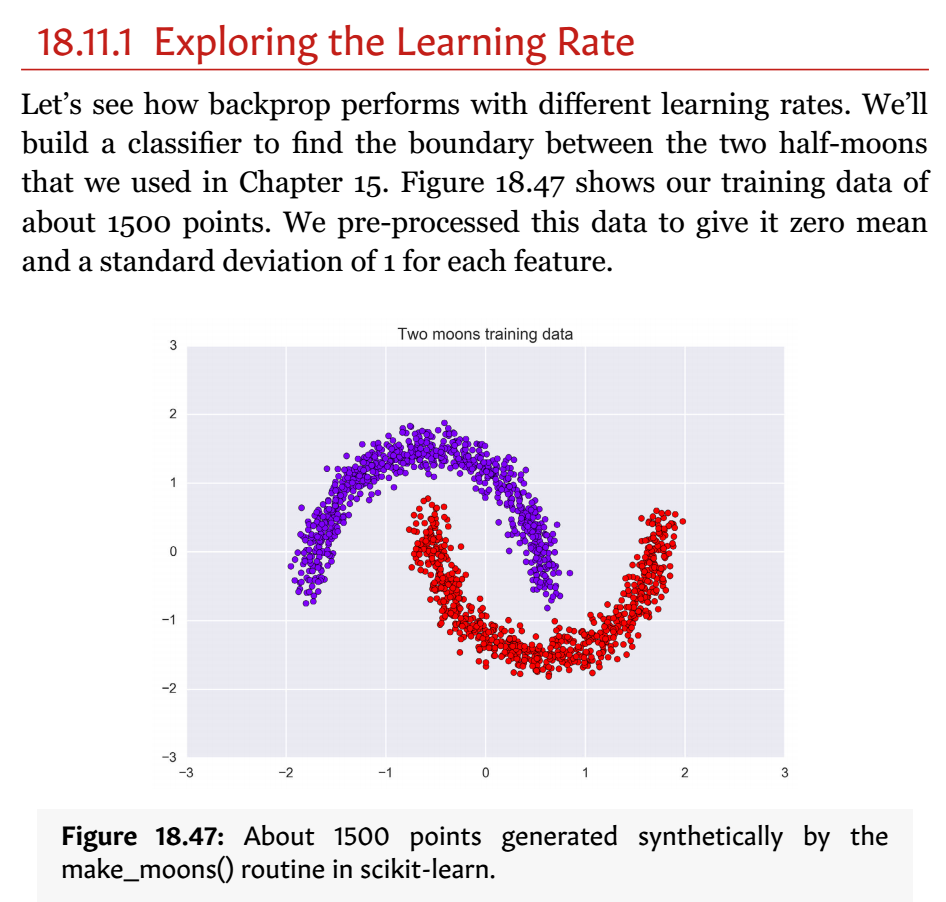

### Define the Dataset class

In [6]:
class TwoMoonsDataset(Dataset):
    """Two Moons dataset."""

    def __init__(self, noise=0.08, n_samples=1500):
        """
        Args:
            noise (float): Amount of noise to use.
            n_samples (int): Number of samples to generate.
        """
        np.random.seed(42)
        (moons_xy, moons_labels) = make_moons(n_samples=n_samples, noise=noise)
        self.sample = preprocessing.scale(moons_xy.astype(float))
        self.target = moons_labels

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return (self.sample[idx], self.target[idx])

### Create the training set and test set loaders
Here we test on the same data we train with--the random seed is the same in the class and we have the same noise and number of points.

In [7]:
# DataLoaders for train and test data
train_loader = torch.utils.data.DataLoader(TwoMoonsDataset(n_samples=1500, noise=0.08), batch_size=args.batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(TwoMoonsDataset(n_samples=1500, noise=0.08), batch_size=args.test_batch_size, **kwargs)

### Plot the two datasets to make sure they look right

In [8]:
def plot_moons(dataset, title):
    clr_list = ['#8800FF', '#FF0000']
    clrs = [clr_list[v] for v in dataset.target]

    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.scatter(dataset.sample[:,0], dataset.sample[:,1], c=clrs, s=15, linewidths=0.5, edgecolors='k')

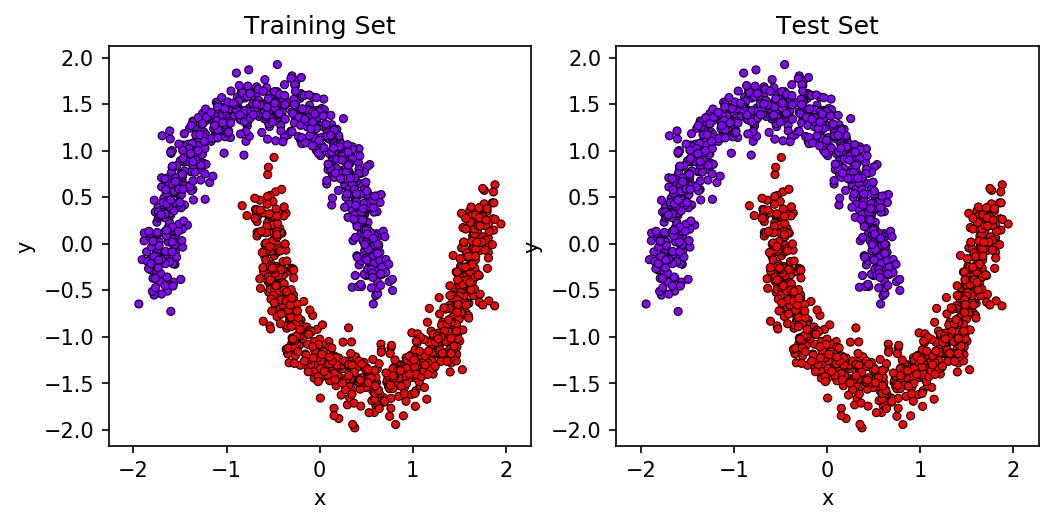

In [9]:
plt.figure(figsize=(8,12), dpi=150)
plt.subplot(3, 2, 1)
plot_moons(train_loader.dataset, 'Training Set')

plt.subplot(3, 2, 2)
plot_moons(test_loader.dataset, 'Test Set')

# Create Two-Layer Network
As noted below, Andrew Glassner includes a bias term in each activation and the network has a total of 37 parameters

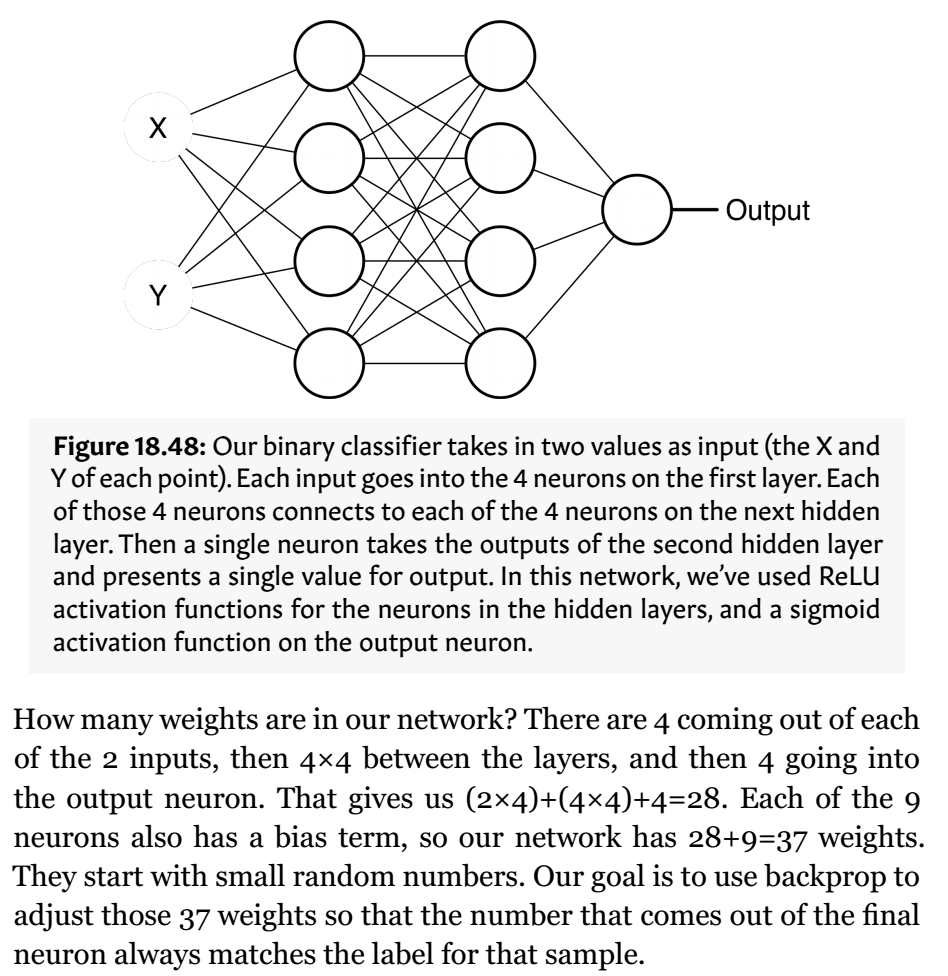

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 4, bias=True)
        self.fc2 = nn.Linear(4, 4, bias=True)
        self.fc3 = nn.Linear(4, 1, bias=True)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [11]:
device = torch.device("cpu")
model = Net().float().to(device)

### Print Network Dimensions and Weights
We show 37 parameters below, which matches Glassners

In [12]:
def print_model_size(model):
    total_model_size = 0
    print("Model's state_dict:\n")
    # print out size of each set of parameter
    for param_tensor in model.state_dict():
        sz = model.state_dict()[param_tensor].size()

        # skip empty parameters (like batch normalization history length)
        if len(sz) == 0:
            continue

        total_model_size += np.prod(sz)
        if len(sz) > 1:
            print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
        else:
            print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))
        print('{}\n'.format(model.state_dict()[param_tensor]))
        
    # print out total
    print('\n{:43} : {:,}'.format('Total Model Size',total_model_size))

In [13]:
print_model_size(model)

Model's state_dict:

fc1.weight       torch.Size([4, 2])         : 4 x 2 = 8
tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597]])

fc1.bias         torch.Size([4])            : 4
tensor([ 0.0983, -0.0866,  0.1961,  0.0349])

fc2.weight       torch.Size([4, 4])         : 4 x 4 = 16
tensor([[ 0.1826, -0.1949, -0.0365, -0.0450],
        [ 0.0725, -0.0020,  0.4371,  0.1556],
        [-0.1862, -0.3020, -0.0838, -0.2157],
        [-0.1602,  0.0239,  0.2981,  0.2718]])

fc2.bias         torch.Size([4])            : 4
tensor([-0.4888,  0.3100,  0.1397,  0.4743])

fc3.weight       torch.Size([1, 4])         : 1 x 4 = 4
tensor([[ 0.3300, -0.4556, -0.4754, -0.2412]])

fc3.bias         torch.Size([1])            : 1
tensor([0.4391])


Total Model Size                            : 37


### Visualize Cost Landscape
scikit has an example that plots decision surfaces
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [14]:
def plot_decision_surface(dataset, model):
    # Get samples
    X = dataset.sample
    
    # Count number correct
    Z = model(torch.tensor(X).float())
    pred = torch.round(Z).long() # Round to 0/1
    x = torch.tensor(dataset.target)
    correct = pred.eq(x.view_as(pred)).sum().item()
    total = len(pred)
    
    # Get meshgrid for surface
    h = 0.02    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Classify each point on the grid
    X_grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
    Z_grid = model(X_grid).detach().numpy()
    
    # Plot decision surface
    fig = plt.figure(figsize=(5,5), dpi=100)
    canvas = FigureCanvas(fig)
    plt.title('Decision Surface: {} out of {} correct'.format(correct,total))
    plt.tight_layout()
    
    Z_grid = Z_grid.reshape(xx.shape)
    cm = plt.cm.RdBu
    plt.contourf(xx, yy, Z_grid, cmap=cm, alpha=.8)
    #plt.xlim(xx.min(), xx.max())
    #plt.ylim(yy.min(), yy.max())
    #plt.xticks()
    #plt.yticks()

    # Plot samples
    X = dataset.sample
    y_train=dataset.target
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')

    canvas.draw()       # draw the canvas, cache the renderer
    s, (width, height) = canvas.print_to_buffer()
    image = np.frombuffer(s, np.uint8).reshape((height, width, 4))

    plt.show()
    return(image)

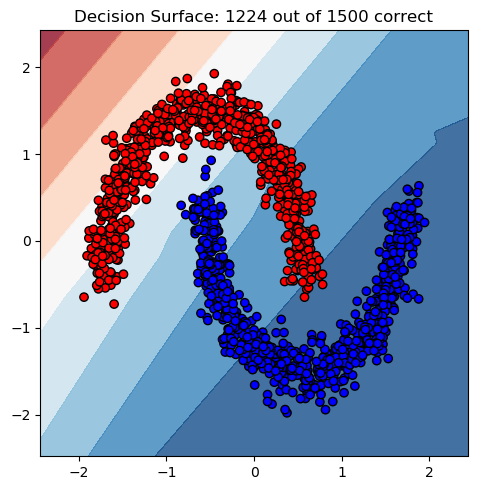

In [15]:
img=plot_decision_surface(test_loader.dataset, model)

# Train the Network

In [16]:
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
#optimizer = optim.Adadelta(model.parameters())
loss_criterion = nn.MSELoss()
#loss_criterion = nn.CrossEntropyLoss(reduction='sum')

In [17]:
def train(args, model, device, train_loader, optimizer, epoch):
    # Set model to be in training mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        loss = loss_criterion(output, target.float())
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{:5}/{} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()/len(data)))

In [18]:
def test(args, model, device, test_loader):
    # Set model to be in testing mode
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.float())
            test_loss += loss_criterion(output, target.float()).item() # sum up batch loss
            #pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            pred = torch.round(output).long() # Round to 0/1
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [19]:
def run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch):
    train_start = time.perf_counter()
    train(args, model, device, train_loader, optimizer, epoch)
    train_end = time.perf_counter()
    train_delta = train_end - train_start

    print("Training took {:.1f}s.\n".format(train_delta))

    test_start = time.perf_counter()
    test(args, model, device, test_loader)
    test_end = time.perf_counter()
    test_delta = test_end - test_start
    
    print("Testing took {:.1f}s.\n".format(test_delta))   

Initialized:
Test set: Average loss: 0.0017, Accuracy: 1224/1500 (82%)



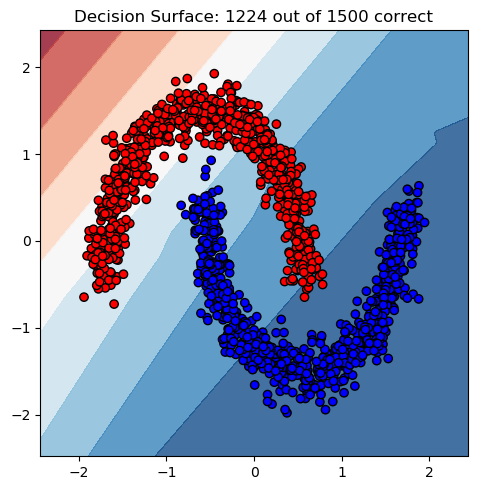

Train Epoch: 1 [    0/1500 (  0%)]	Loss: 0.205385
Train Epoch: 1 [  300/1500 ( 20%)]	Loss: 0.012054
Train Epoch: 1 [  600/1500 ( 40%)]	Loss: 0.003868
Train Epoch: 1 [  900/1500 ( 60%)]	Loss: 0.647011
Train Epoch: 1 [ 1200/1500 ( 80%)]	Loss: 0.003344
Training took 1.2s.

Test set: Average loss: 0.0025, Accuracy: 1332/1500 (89%)
Testing took 0.0s.



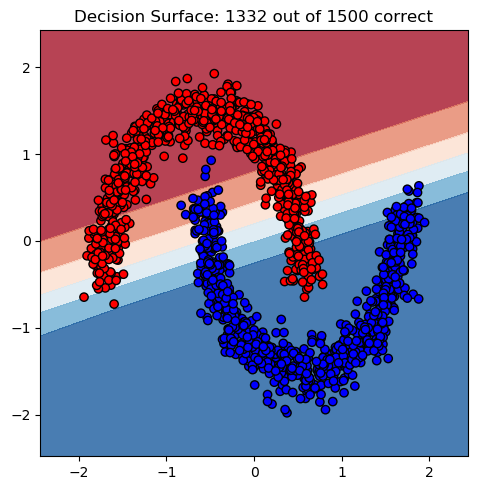

Train Epoch: 2 [    0/1500 (  0%)]	Loss: 0.018483
Train Epoch: 2 [  300/1500 ( 20%)]	Loss: 0.000383
Train Epoch: 2 [  600/1500 ( 40%)]	Loss: 0.001463
Train Epoch: 2 [  900/1500 ( 60%)]	Loss: 0.711385
Train Epoch: 2 [ 1200/1500 ( 80%)]	Loss: 0.002494
Training took 0.8s.

Test set: Average loss: 0.0026, Accuracy: 1332/1500 (89%)
Testing took 0.0s.



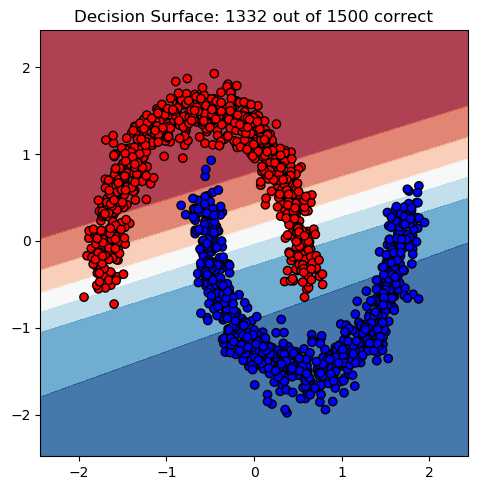

Train Epoch: 3 [    0/1500 (  0%)]	Loss: 0.009135
Train Epoch: 3 [  300/1500 ( 20%)]	Loss: 0.000479
Train Epoch: 3 [  600/1500 ( 40%)]	Loss: 0.001554
Train Epoch: 3 [  900/1500 ( 60%)]	Loss: 0.696503
Train Epoch: 3 [ 1200/1500 ( 80%)]	Loss: 0.002598
Training took 1.1s.

Test set: Average loss: 0.0026, Accuracy: 1335/1500 (89%)
Testing took 0.0s.



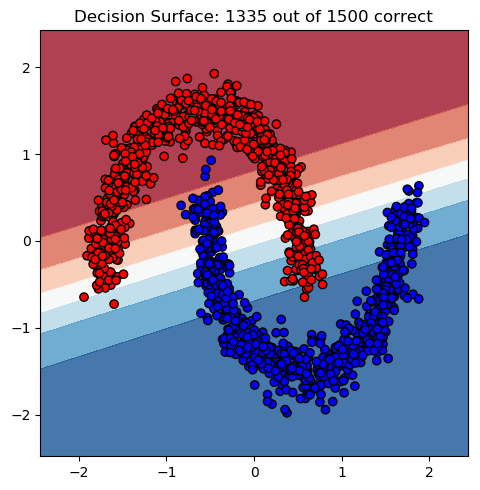

Train Epoch: 4 [    0/1500 (  0%)]	Loss: 0.006101
Train Epoch: 4 [  300/1500 ( 20%)]	Loss: 0.000606
Train Epoch: 4 [  600/1500 ( 40%)]	Loss: 0.001659
Train Epoch: 4 [  900/1500 ( 60%)]	Loss: 0.694482
Train Epoch: 4 [ 1200/1500 ( 80%)]	Loss: 0.002365
Training took 0.9s.

Test set: Average loss: 0.0026, Accuracy: 1336/1500 (89%)
Testing took 0.0s.



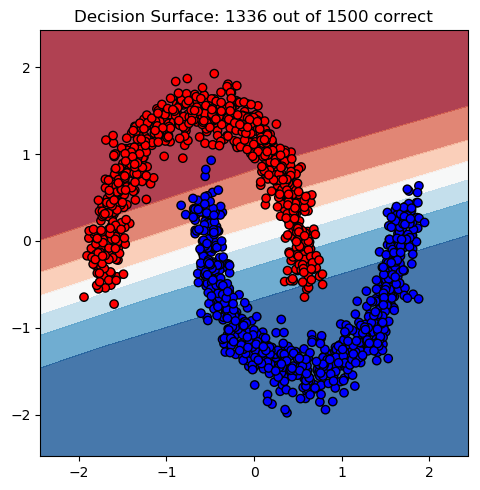

Train Epoch: 5 [    0/1500 (  0%)]	Loss: 0.004633
Train Epoch: 5 [  300/1500 ( 20%)]	Loss: 0.000630
Train Epoch: 5 [  600/1500 ( 40%)]	Loss: 0.001654
Train Epoch: 5 [  900/1500 ( 60%)]	Loss: 0.693771
Train Epoch: 5 [ 1200/1500 ( 80%)]	Loss: 0.002151
Training took 0.6s.

Test set: Average loss: 0.0026, Accuracy: 1341/1500 (89%)
Testing took 0.0s.



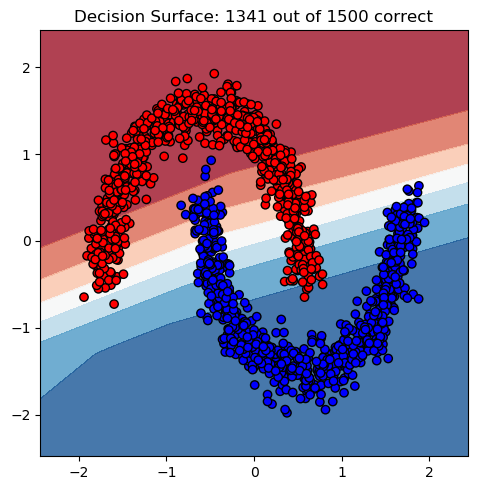

Train Epoch: 6 [    0/1500 (  0%)]	Loss: 0.003721
Train Epoch: 6 [  300/1500 ( 20%)]	Loss: 0.000803
Train Epoch: 6 [  600/1500 ( 40%)]	Loss: 0.001600
Train Epoch: 6 [  900/1500 ( 60%)]	Loss: 0.700050
Train Epoch: 6 [ 1200/1500 ( 80%)]	Loss: 0.002025
Training took 0.7s.

Test set: Average loss: 0.0027, Accuracy: 1349/1500 (90%)
Testing took 0.0s.



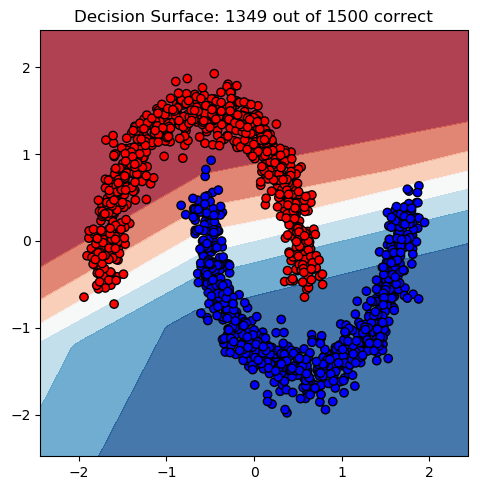

Train Epoch: 7 [    0/1500 (  0%)]	Loss: 0.003054
Train Epoch: 7 [  300/1500 ( 20%)]	Loss: 0.001723
Train Epoch: 7 [  600/1500 ( 40%)]	Loss: 0.001464
Train Epoch: 7 [  900/1500 ( 60%)]	Loss: 0.702186
Train Epoch: 7 [ 1200/1500 ( 80%)]	Loss: 0.001963
Training took 1.2s.

Test set: Average loss: 0.0027, Accuracy: 1364/1500 (91%)
Testing took 0.0s.



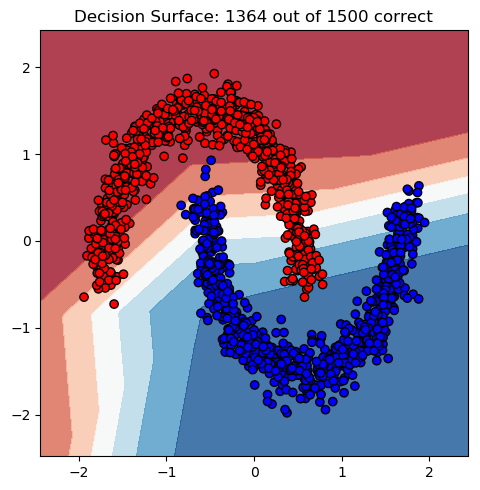

Train Epoch: 8 [    0/1500 (  0%)]	Loss: 0.002470
Train Epoch: 8 [  300/1500 ( 20%)]	Loss: 0.002362
Train Epoch: 8 [  600/1500 ( 40%)]	Loss: 0.001124
Train Epoch: 8 [  900/1500 ( 60%)]	Loss: 0.646864
Train Epoch: 8 [ 1200/1500 ( 80%)]	Loss: 0.002190
Training took 1.0s.

Test set: Average loss: 0.0027, Accuracy: 1425/1500 (95%)
Testing took 0.0s.



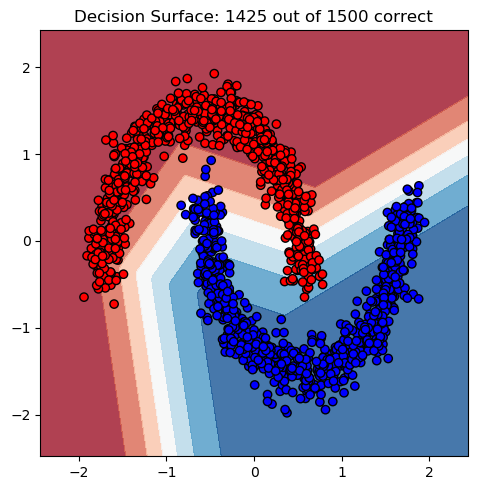

Train Epoch: 9 [    0/1500 (  0%)]	Loss: 0.002016
Train Epoch: 9 [  300/1500 ( 20%)]	Loss: 0.005335
Train Epoch: 9 [  600/1500 ( 40%)]	Loss: 0.001439
Train Epoch: 9 [  900/1500 ( 60%)]	Loss: 0.201567
Train Epoch: 9 [ 1200/1500 ( 80%)]	Loss: 0.006464
Training took 1.0s.

Test set: Average loss: 0.0029, Accuracy: 1492/1500 (99%)
Testing took 0.0s.



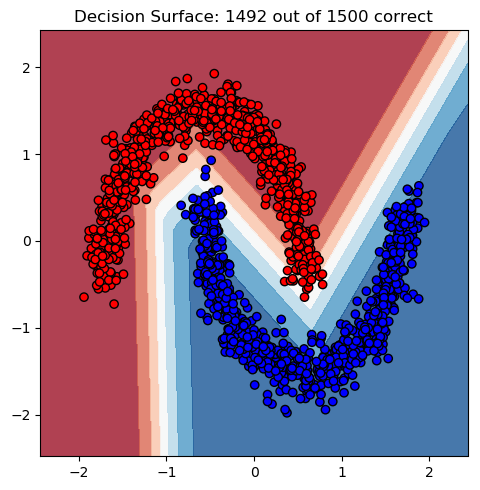

Train Epoch: 10 [    0/1500 (  0%)]	Loss: 0.002917
Train Epoch: 10 [  300/1500 ( 20%)]	Loss: 0.008325
Train Epoch: 10 [  600/1500 ( 40%)]	Loss: 0.000438
Train Epoch: 10 [  900/1500 ( 60%)]	Loss: 0.066436
Train Epoch: 10 [ 1200/1500 ( 80%)]	Loss: 0.001602
Training took 1.0s.

Test set: Average loss: 0.0031, Accuracy: 1498/1500 (100%)
Testing took 0.0s.



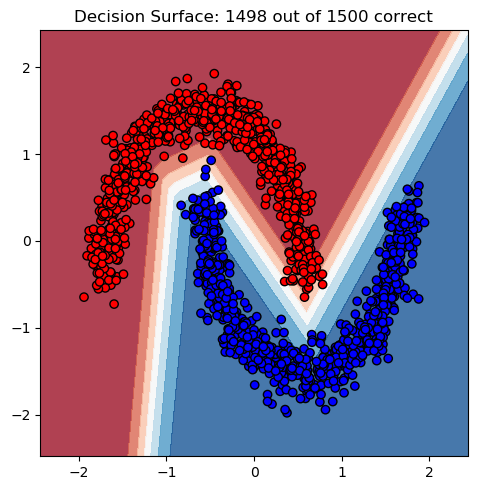

Train Epoch: 11 [    0/1500 (  0%)]	Loss: 0.003264
Train Epoch: 11 [  300/1500 ( 20%)]	Loss: 0.001371
Train Epoch: 11 [  600/1500 ( 40%)]	Loss: 0.000082
Train Epoch: 11 [  900/1500 ( 60%)]	Loss: 0.033423
Train Epoch: 11 [ 1200/1500 ( 80%)]	Loss: 0.000749
Training took 0.6s.

Test set: Average loss: 0.0031, Accuracy: 1498/1500 (100%)
Testing took 0.0s.



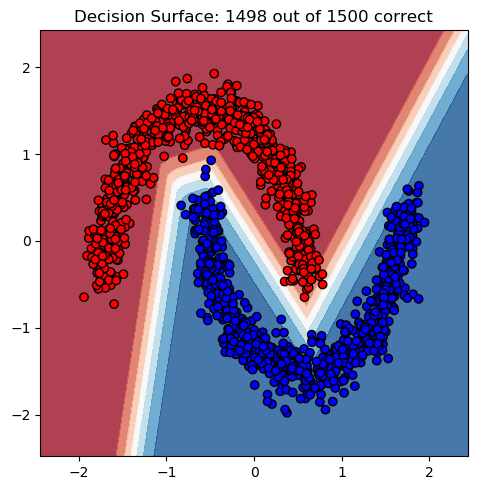

Train Epoch: 12 [    0/1500 (  0%)]	Loss: 0.002780
Train Epoch: 12 [  300/1500 ( 20%)]	Loss: 0.000703
Train Epoch: 12 [  600/1500 ( 40%)]	Loss: 0.000038
Train Epoch: 12 [  900/1500 ( 60%)]	Loss: 0.020340
Train Epoch: 12 [ 1200/1500 ( 80%)]	Loss: 0.000451
Training took 0.6s.

Test set: Average loss: 0.0031, Accuracy: 1498/1500 (100%)
Testing took 0.0s.



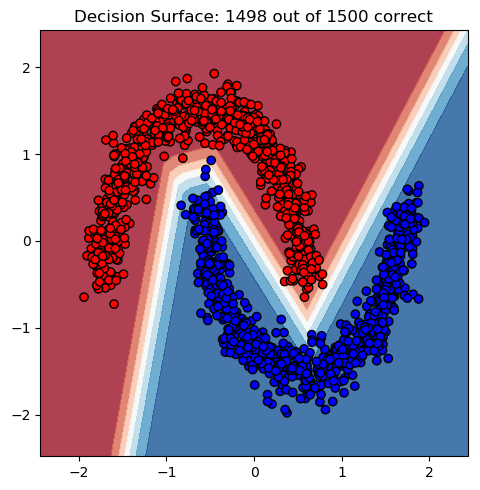

Train Epoch: 13 [    0/1500 (  0%)]	Loss: 0.001978
Train Epoch: 13 [  300/1500 ( 20%)]	Loss: 0.000389
Train Epoch: 13 [  600/1500 ( 40%)]	Loss: 0.000015
Train Epoch: 13 [  900/1500 ( 60%)]	Loss: 0.014647
Train Epoch: 13 [ 1200/1500 ( 80%)]	Loss: 0.000291
Training took 1.1s.

Test set: Average loss: 0.0032, Accuracy: 1499/1500 (100%)
Testing took 0.0s.



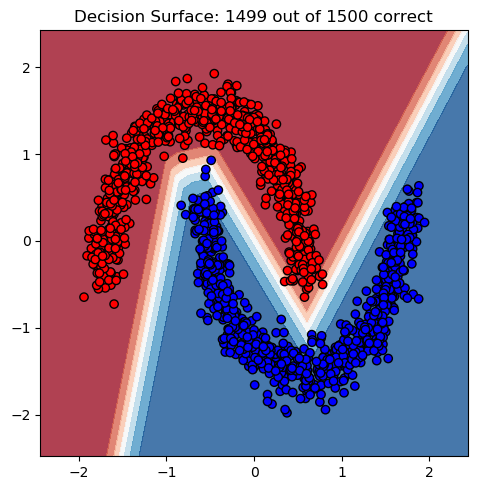

Train Epoch: 14 [    0/1500 (  0%)]	Loss: 0.001594
Train Epoch: 14 [  300/1500 ( 20%)]	Loss: 0.000219
Train Epoch: 14 [  600/1500 ( 40%)]	Loss: 0.000006
Train Epoch: 14 [  900/1500 ( 60%)]	Loss: 0.006051
Train Epoch: 14 [ 1200/1500 ( 80%)]	Loss: 0.000173
Training took 0.9s.

Test set: Average loss: 0.0032, Accuracy: 1499/1500 (100%)
Testing took 0.0s.



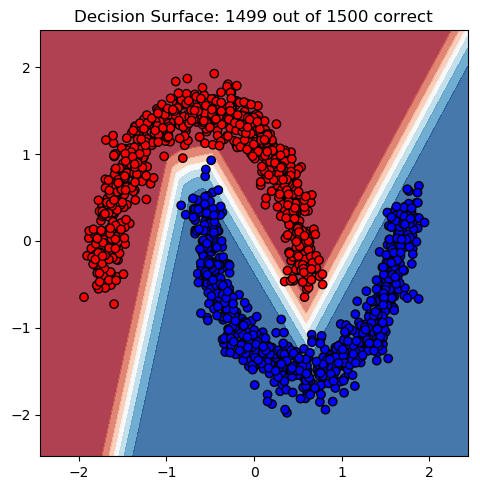

Train Epoch: 15 [    0/1500 (  0%)]	Loss: 0.001539
Train Epoch: 15 [  300/1500 ( 20%)]	Loss: 0.000150
Train Epoch: 15 [  600/1500 ( 40%)]	Loss: 0.000001
Train Epoch: 15 [  900/1500 ( 60%)]	Loss: 0.004917
Train Epoch: 15 [ 1200/1500 ( 80%)]	Loss: 0.000107
Training took 0.6s.

Test set: Average loss: 0.0032, Accuracy: 1500/1500 (100%)
Testing took 0.0s.



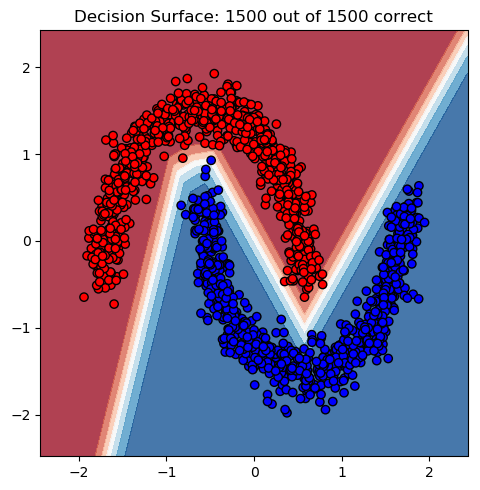

Train Epoch: 16 [    0/1500 (  0%)]	Loss: 0.001894
Train Epoch: 16 [  300/1500 ( 20%)]	Loss: 0.000052
Train Epoch: 16 [  600/1500 ( 40%)]	Loss: 0.000002
Train Epoch: 16 [  900/1500 ( 60%)]	Loss: 0.003357
Train Epoch: 16 [ 1200/1500 ( 80%)]	Loss: 0.000086
Training took 0.8s.

Test set: Average loss: 0.0032, Accuracy: 1500/1500 (100%)
Testing took 0.0s.



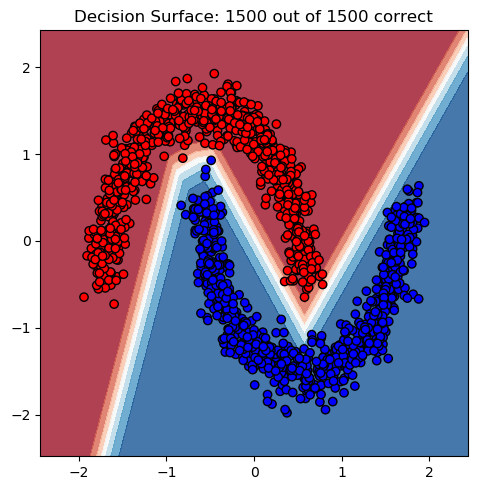

Train Epoch: 17 [    0/1500 (  0%)]	Loss: 0.001523
Train Epoch: 17 [  300/1500 ( 20%)]	Loss: 0.000053
Train Epoch: 17 [  600/1500 ( 40%)]	Loss: 0.000001
Train Epoch: 17 [  900/1500 ( 60%)]	Loss: 0.002743
Train Epoch: 17 [ 1200/1500 ( 80%)]	Loss: 0.000056
Training took 1.0s.

Test set: Average loss: 0.0032, Accuracy: 1500/1500 (100%)
Testing took 0.0s.



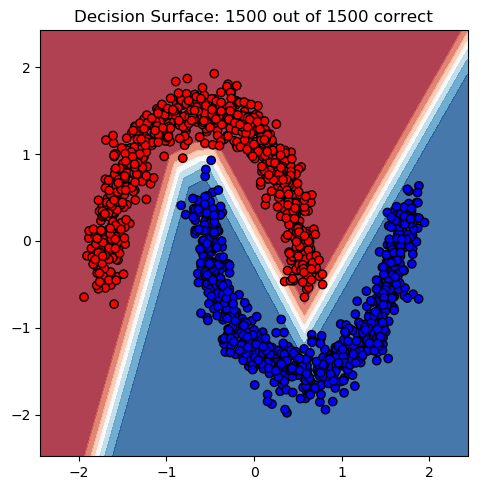

Train Epoch: 18 [    0/1500 (  0%)]	Loss: 0.001485
Train Epoch: 18 [  300/1500 ( 20%)]	Loss: 0.000039
Train Epoch: 18 [  600/1500 ( 40%)]	Loss: 0.000001
Train Epoch: 18 [  900/1500 ( 60%)]	Loss: 0.002026
Train Epoch: 18 [ 1200/1500 ( 80%)]	Loss: 0.000040
Training took 1.1s.

Test set: Average loss: 0.0032, Accuracy: 1500/1500 (100%)
Testing took 0.0s.



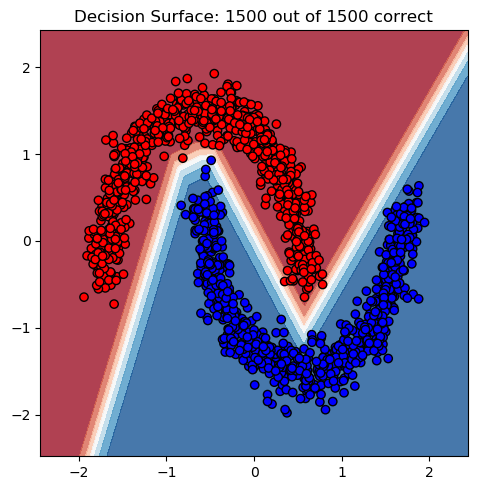

Train Epoch: 19 [    0/1500 (  0%)]	Loss: 0.001486
Train Epoch: 19 [  300/1500 ( 20%)]	Loss: 0.000028
Train Epoch: 19 [  600/1500 ( 40%)]	Loss: 0.000000
Train Epoch: 19 [  900/1500 ( 60%)]	Loss: 0.001584
Train Epoch: 19 [ 1200/1500 ( 80%)]	Loss: 0.000030
Training took 0.6s.

Test set: Average loss: 0.0032, Accuracy: 1500/1500 (100%)
Testing took 0.0s.



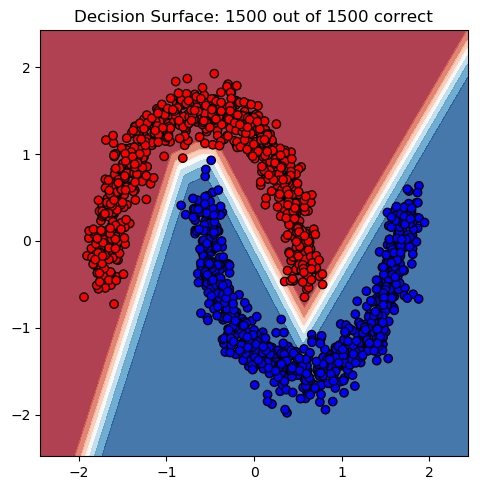

Train Epoch: 20 [    0/1500 (  0%)]	Loss: 0.001453
Train Epoch: 20 [  300/1500 ( 20%)]	Loss: 0.000020
Train Epoch: 20 [  600/1500 ( 40%)]	Loss: 0.000000
Train Epoch: 20 [  900/1500 ( 60%)]	Loss: 0.001277
Train Epoch: 20 [ 1200/1500 ( 80%)]	Loss: 0.000023
Training took 0.6s.

Test set: Average loss: 0.0032, Accuracy: 1500/1500 (100%)
Testing took 0.0s.



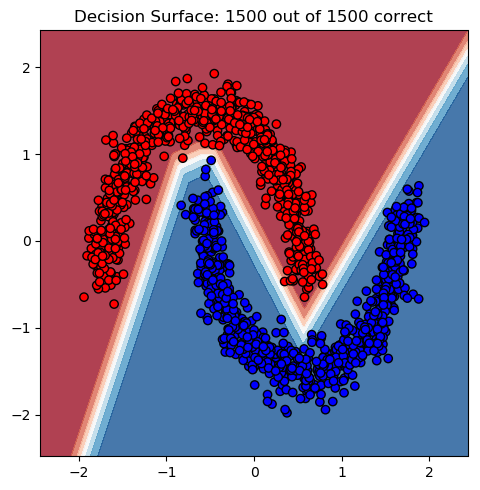

In [20]:
print("Initialized:")
test(args, model, device, test_loader)
print("")

images = []
img = plot_decision_surface(test_loader.dataset, model)
images.append(img)

for epoch in range(1, args.epochs + 1):
    run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch)
    img = plot_decision_surface(test_loader.dataset, model)
    images.append(img)

x=imageio.mimsave('two_moons_optimization.gif', images)

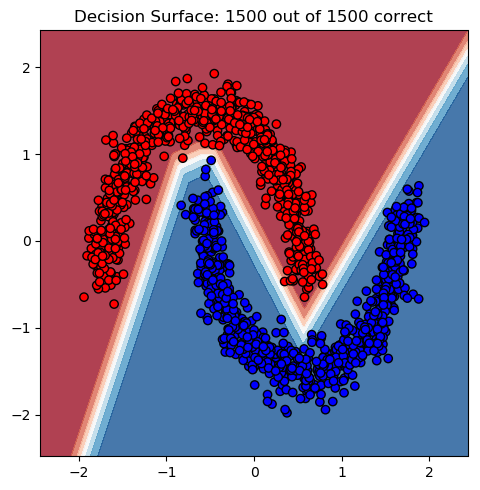

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

In [21]:
plot_decision_surface(test_loader.dataset, model)